In [195]:
import numpy as np
import numpy.lib.recfunctions as rf

import tonic
import tonic.transforms as transforms
from tonic.datasets import DVSGesture
from tonic import DiskCachedDataset

import matplotlib.pyplot as plt
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader

import snntorch as snn
from snntorch import functional as SF

In [196]:
config = {
    "data_path" : r"/home/emercad3",
    "cache_path" : r"/home/emercad3/cache",
    
    "beta": 0.5,
    "thresh_1": 1,
    "thresh_2": 1,
    "thresh_3": 1,
    "is_batch_norm": True,
}

In [197]:
def normalize_frames(frames):
    # Convert to numpy if it's a torch tensor
    if isinstance(frames, torch.Tensor):
        frames = frames.cpu().numpy()

    # Normalize frames
    frames_min = frames.min()
    frames_max = frames.max()
    normalized_frames = (frames - frames_min) / (frames_max - frames_min)
    
    return normalized_frames


In [198]:
def to_frames(events):
    frame_transform = transforms.ToFrame(
        sensor_size=tonic.datasets.DVSGesture.sensor_size,
        n_time_bins=100
    )
    frames = frame_transform(events)
    return frames



In [199]:
# Assuming DVSGesture is properly imported from tonic.datasets
def prepare_dataset(dataset_path, is_train):
    dataset = tonic.datasets.DVSGesture(save_to=dataset_path, train=is_train)
    return dataset

# Prepare the datasets
train_dataset = prepare_dataset(config["data_path"], True)
test_dataset = prepare_dataset(config["data_path"], False)


Train dataset contains 1077 samples.
There are 520335 events in the selected sample.
A single event: (97, 87, True, 25) as (x-pos, y-pos, polarity, timestamp).
(100, 2, 128, 128) 8


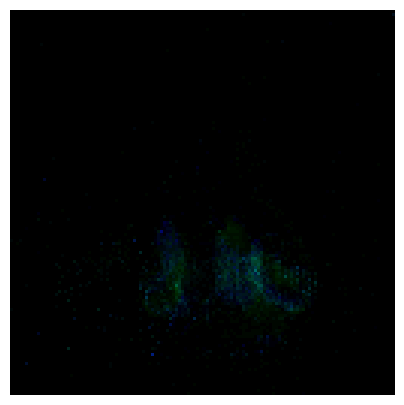

In [200]:
# Load a sample from the training dataset
events, label = train_dataset[0]

# Convert the events to frames
frames = to_frames(events)

print("Train dataset contains", len(train_dataset), "samples.")
print("There are", len(events), "events in the selected sample.")
print("A single event:", events[0], "as (x-pos, y-pos, polarity, timestamp).")
print(frames.shape, label)


normalized_frames = normalize_frames(frames)
# Visualize the normalized frames
ani = tonic.utils.plot_animation(normalized_frames)
HTML(ani.to_jshtml())


(32, 2, 32, 32) 8


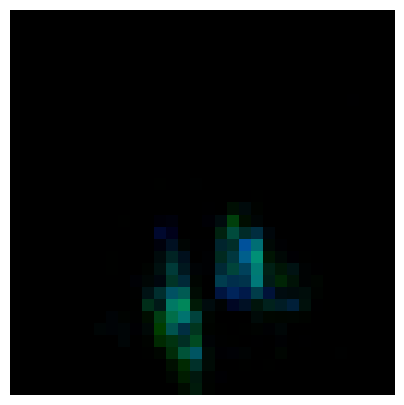

In [201]:
w, h = 32, 32
n_frames = 32
debug = False
filter_time = 1_000

transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=filter_time), # removes outlier events with inactive surrounding pixels for 10ms
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(w,h)), # downsampling image
    tonic.transforms.ToFrame(sensor_size=(w,h,2), n_time_bins=n_frames), # n_frames frames per trail
])


train2 = DVSGesture(save_to=config["data_path"], train=True, transform=transforms)
test2 = DVSGesture(save_to=config["data_path"], train=False, transform=transforms)

cached_train = train2 if debug else DiskCachedDataset(train2, cache_path=config["cache_path"])
cached_test = test2 if debug else DiskCachedDataset(test2, cache_path=config["cache_path"])

frames, label = cached_train[0]
print(frames.shape, label)

normalized_frames = normalize_frames(frames)
ani = tonic.utils.plot_animation(normalized_frames)
HTML(ani.to_jshtml())

In [202]:
class Binarize(Function):
  @staticmethod
  def forward(weight_ref, inpt):
    return inpt.sign().clamp(min=-1)

  @staticmethod
  def backward(weight_ref, gradient_out):
    gradient_in = gradient_out.clone()
    return gradient_in
  
  
class BinaryConv2d(nn.Conv2d):
  def __init__(self, *kargs, **kwargs):
    super(BinaryConv2d, self).__init__(*kargs, **kwargs)

  def forward(self, inpt):
    binarized_weights = Binarize.apply(self.weight)
    return F.conv2d(inpt, binarized_weights)

  def reset_params(self):
    nn.init.xavier_normal_(self.weight)
    if self.bias is not None:
      nn.init.constant(self.bias, 0)
      
class BinaryLinear(nn.Linear):
  def __init__(self, *kargs, **kwargs):
    super(BinaryLinear, self).__init__(*kargs, **kwargs)

    def forward(self, inpt):
        bin_weights = Binarize.apply(self.weight)
        if self.bias is None:
            return F.linear(inpt, bin_weights)
        else:
            return F.linear(inpt, bin_weights, self.bias)

    def reset_parameters(self):
        torch.nn.init.xavier_normal_(self.weight)
        if self.bias is not None:
            torch.nn.init.constant_(self.bias, 0)



In [203]:
class BSNN(nn.Module):
    def __init__(self, config):
        super(BSNN, self).__init__()

        self.thresh_1 = config["thresh_1"]
        self.thresh_2 = config["thresh_2"]
        self.thresh_3 = config["thresh_3"]
        self.beta = config["beta"]
        # self.num_steps = config["num_steps"]

        self.is_batch_norm = config["is_batch_norm"]
        # self.dropout = config["dropout"]

        self.bin_conv_1 = BinaryConv2d(in_channels=2, out_channels=12, kernel_size=5)
        self.batch_norm_1 = nn.BatchNorm2d(num_features=12)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2)
        self.lif_1 = snn.Leaky(beta=self.beta, threshold=self.thresh_1)

        self.bin_conv_2 = BinaryConv2d(in_channels=12, out_channels=32, kernel_size=5)
        self.batch_norm_2 = nn.BatchNorm2d(num_features=32)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2)
        self.lif_2 = snn.Leaky(beta=self.beta, threshold=self.thresh_2)

        self.flatten = nn.Flatten()
        self.bin_fully_connected_1 = BinaryLinear(in_features=800, out_features=11)
        self.lif_3 = snn.Leaky(beta=self.beta, threshold=self.thresh_3)


    def forward(self, inpt):
        mem_1 = self.lif_1.init_leaky()
        mem_2 = self.lif_2.init_leaky()
        mem_3 = self.lif_3.init_leaky()

        spike_3_rec = []
        # mem_3_rec = []

        for step in range(inpt.size(0)):
            print(f"Shape of inpt: {inpt.shape}")
            
            current_1 = self.bin_conv_1(inpt)
            print(f"Shape after bin_conv_1: {current_1.shape}")

            current_1 = self.batch_norm_1(current_1) if self.is_batch_norm else current_1
            print(f"Shape after batch_norm_1: {current_1.shape}")
            
            current_1 = self.max_pool_1(current_1)
            print(f"Shape after max_pool_1: {current_1.shape}")

            spike_1, mem_1 = self.lif_1(current_1, mem_1)

            current_2 = self.bin_conv_2(spike_1)
            print(f"Shape after bin_conv_2: {current_2.shape}")

            current_2 = self.batch_norm_2(current_2) if self.is_batch_norm else current_2
            print(f"Shape after batch_norm_2: {current_2.shape}")
            
            current_2 = self.max_pool_2(current_2)
            print(f"Shape after max_pool_2: {current_2.shape}")

            spike_2, mem_2 = self.lif_2(current_2, mem_2)

            current_3 = self.flatten(spike_2)
            print(f"Shape after flatten: {current_3.shape}")

            current_3 = self.bin_fully_connected_1(current_3)
            print(f"Shape after bin_fully_connected_1: {current_3.shape}")

            spike_3, mem_3 = self.lif_3(current_3, mem_3)

            spike_3_rec.append(spike_3)
            # mem_3_rec.append(mem_3)

        return torch.stack(spike_3_rec, dim=0)

In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BSNN(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
# loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
loss_fn = torch.nn.CrossEntropyLoss()

In [205]:
def train_model(model, train_loader, optimizer, device, loss_fn):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Assuming data is already a tensor or you have converted it as necessary
        data = data.to(device)
        
        # Directly ensure targets is a long tensor without converting to NumPy and back
        targets = targets.to(device)

        # Forward pass
        spk_rec = model(data)
        
        # Compute loss
        loss = loss_fn(spk_rec, targets)  # Ensure spk_rec and targets are correctly shaped
        total_loss += loss.item() * data.size(0)  # Accumulate total loss
        
        # Calculate accuracy
        preds = spk_rec.argmax(dim=1)
        total_correct += preds.eq(targets).sum().item()
        total_samples += data.size(0)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average loss and accuracy over the epoch
    epoch_loss = total_loss / total_samples
    epoch_acc = total_correct / total_samples

    print(f"Training - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc * 100:.2f}%")
    return epoch_loss, epoch_acc



In [206]:
def validate_model(model, test_loader, device, loss_fn):
    model.eval()
    test_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data, targets in test_loader:
            data = torch.from_numpy(data).float().to(device)
            targets = torch.from_numpy(targets).int().to(device)
            
            output = model(data)
            
            # Compute loss for the current batch.
            test_loss += loss_fn(output.squeeze(), targets).item() * data.size(0)  # Multiply by batch size
            
            # Compute accuracy for the current batch.
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            total_correct += pred.eq(targets.view_as(pred)).sum().item()
            total_samples += data.size(0)

    test_loss /= total_samples
    accuracy = total_correct / total_samples
    
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {accuracy * 100:.2f}%\n")


In [207]:
train_loader = DataLoader(cached_train, batch_size=32, shuffle=True, drop_last=True, collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = DataLoader(cached_test, batch_size=32, shuffle=False, drop_last=False, collate_fn=tonic.collation.PadTensors(batch_first=False))

In [208]:
num_epochs = 10
train_losses, train_accuracies = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_model(model, train_loader, optimizer, device, loss_fn)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    
validate_model(model, test_loader, device, loss_fn)


Epoch 1/10
Shape of inpt: torch.Size([32, 32, 2, 32, 32])


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [32, 32, 2, 32, 32]